In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
from mvl2 import genData2
import numpyro
from mvl2.numpyro import model, model_mvn, model_conjugate, infer, run
from torch import tensor
import matplotlib.pyplot as plt
import numpyro.distributions as dist
from numpyro import optim
from numpyro.infer import SVI
from numpyro.infer.autoguide import *
from numpyro.infer.elbo import TraceGraph_ELBO
from jax import random

In [10]:
r_p = tensor([[1., 0], [0, 1.]])
r_g = tensor([[1., .5], [.5, 1.]])
v_p = tensor([.05, .05])
h2 = tensor([.9, .9])

popgen_params = genData2.get_popgen_param(h2=h2, v_p=v_p, r_p=r_p, r_g=r_g)

sim_params = {
    "pi": tensor([.1, .1, .05]),
    **popgen_params,
    "RR_mean": tensor([3., 2.]),
    "PV_shape": tensor(1.),
    "PV_mean": tensor(1e-4),
    "PD": tensor([.01, .01]),
    "n_cases": tensor([1.5e4, 1.5e4, 4e3]),
    "n_ctrls": tensor(5e4),
    "fudge_factor": .1
}
sim_data = genData2.gen_counts(**sim_params)


/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


In [11]:
sim_data["PVDs"].mean(0)

tensor([9.9627e-05, 1.3032e-04, 1.1551e-04, 1.5711e-04], dtype=torch.float64)

In [12]:
print(sim_data["PVDs"][sim_data["unaffected_genes"]].mean(0))
for i in range(len(sim_data["affected_genes"])):
    print(f"mean affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].mean(0))
    print(f"std affects {i + 1}", sim_data["PVDs"][sim_data["affected_genes"][i]].std(0))


tensor([9.9917e-05, 9.9917e-05, 9.9917e-05, 9.9917e-05], dtype=torch.float64)
mean affects 1 tensor([9.9441e-05, 1.0048e-04, 2.0113e-04, 2.0113e-04], dtype=torch.float64)
std affects 1 tensor([0.0001, 0.0001, 0.0002, 0.0002], dtype=torch.float64)
mean affects 2 tensor([9.6487e-05, 3.0565e-04, 2.0454e-04, 6.3493e-04], dtype=torch.float64)
std affects 2 tensor([9.5974e-05, 3.1076e-04, 2.0975e-04, 6.8285e-04], dtype=torch.float64)
mean affects 3 tensor([9.9215e-05, 3.0431e-04, 1.0131e-04, 3.0431e-04], dtype=torch.float64)
std affects 3 tensor([9.8335e-05, 3.0242e-04, 1.0041e-04, 3.0242e-04], dtype=torch.float64)


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


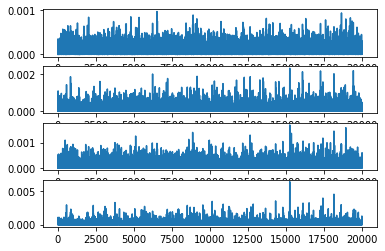

In [13]:
fig, plts = plt.subplots(sim_data["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data["PVDs"][:, i])

In [14]:
sim_params_point_pv = sim_params.copy()
sim_params_point_pv["PV_shape"] = None
sim_data_point_pv = genData2.gen_counts(**sim_params_point_pv)

/home/akotlar/tada/project/mvl2/genData2.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD_z_score = norm.icdf(tensor(1 - PD))
/home/akotlar/tada/project/mvl2/genData2.py:127: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PV = tensor(PV_mean).expand([n_genes,])
/home/akotlar/tada/project/mvl2/genData2.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  PD12V = mvn.cdf(tensor(disease_z_scores))


[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


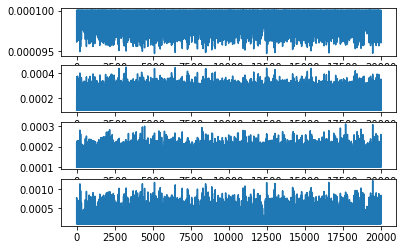

In [15]:
import matplotlib.pyplot as plt
fig, plts = plt.subplots(sim_data_point_pv["PVDs"].shape[1])
print(plts)
for i in range(len(plts)):
    plts[i].plot(sim_data_point_pv["PVDs"][:, i])

In [16]:
run_params = {
    "data": sim_data_point_pv["alt_counts"].numpy(),
    "n_cases": sim_params_point_pv["n_cases"].numpy(),
    "n_ctrls": sim_params_point_pv["n_ctrls"].numpy(),
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 12,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}



In [17]:
sim_params_point_pv["n_cases"]

tensor([15000., 15000.,  4000.])

In [18]:
numpyro.enable_x64(False)
run_params_2 = run_params.copy()
run_params_2['max_K'] = 4
mcmc1, inferred_params1 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:18<00:00, 64.48it/s, 15 steps of size 1.50e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.74      0.02      0.74      0.71      0.77    421.82      1.01
   beta[1]      0.41      0.06      0.41      0.32      0.51    578.78      1.01
   beta[2]      0.71      0.08      0.72      0.57      0.83    337.02      1.00
probs[0,0]      0.60      0.00      0.60      0.59      0.60    470.62      1.00
probs[0,1]      0.17      0.00      0.17      0.17      0.17    716.05      1.00
probs[0,2]      0.19      0.00      0.19      0.18      0.19    490.41      1.00
probs[0,3]      0.05      0.00      0.05      0.04      0.05    626.14      1.00
probs[1,0]      0.43      0.01      0.43      0.41      0.46    532.89      1.01
probs[1,1]      0.37      0.01      0.37      0.36      0.39    772.27      1.00
probs[1,2]      0.10      0.01      0.10      0.09      0.12    525.45      1.00
probs[1,3]      0.09      0.01      0.09      0.08      0.10    537.26      1.00
probs[2,0]      0.33      0

In [11]:
mcmc1_b, inferred_params1_b = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.53it/s, 31 steps of size 1.11e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.21      0.07      0.20      0.10      0.30    205.50      1.00
   beta[1]      0.71      0.03      0.72      0.67      0.76    223.27      1.00
   beta[2]      0.32      0.07      0.31      0.20      0.43    315.28      1.01
 conc[0,0]      4.68      2.66      4.24      0.73      8.61    772.52      1.01
 conc[0,1]      2.63      1.56      2.39      0.21      4.73    765.65      1.00
 conc[0,2]      3.83      2.15      3.38      0.62      6.90    590.59      1.00
 conc[0,3]      1.77      1.15      1.54      0.16      3.33   1091.06      1.00
 conc[1,0]      4.69      3.01      4.06      0.33      8.81    842.75      1.00
 conc[1,1]      2.50      1.65      2.19      0.02      4.67    509.50      1.00
 conc[1,2]      2.53      1.58      2.19      0.27      4.74    715.58      1.00
 conc[1,3]      1.26      0.86      1.11      0.02      2.33   1467.74      1.00
 conc[2,0]      4.04      2

In [12]:
mcmc1_c, inferred_params1_c = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.02it/s, 63 steps of size 8.52e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.51      0.29      0.51      0.04      0.92   1728.62      1.00
   beta[1]      0.50      0.29      0.50      0.06      0.95   1804.29      1.00
   beta[2]      0.50      0.28      0.49      0.06      0.93   1318.74      1.00
 conc[0,0]      1.73      1.61      1.26      0.01      3.99    815.58      1.00
 conc[0,1]      5.92      5.70      4.25      0.04     13.04   1048.75      1.00
 conc[0,2]      5.56      5.51      3.85      0.00     12.20   1188.49      1.00
 conc[0,3]     20.65     20.73     14.02      0.03     46.18   1031.12      1.00
 conc[1,0]      1.71      1.76      1.16      0.02      4.03    340.33      1.00
 conc[1,1]      5.96      5.98      4.05      0.03     13.35    543.91      1.00
 conc[1,2]      5.56      5.39      3.87      0.06     12.90    889.40      1.00
 conc[1,3]     21.65     22.46     15.11      0.09     50.64    786.38      1.00
 conc[2,0]      1.62      1

In [13]:
mcmc1_c2, inferred_params1_c2 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.13it/s, 63 steps of size 8.52e-02. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.51      0.29      0.51      0.04      0.92   1728.62      1.00
   beta[1]      0.50      0.29      0.50      0.06      0.95   1804.29      1.00
   beta[2]      0.50      0.28      0.49      0.06      0.93   1318.74      1.00
 conc[0,0]      1.73      1.61      1.26      0.01      3.99    815.58      1.00
 conc[0,1]      5.92      5.70      4.25      0.04     13.04   1048.75      1.00
 conc[0,2]      5.56      5.51      3.85      0.00     12.20   1188.49      1.00
 conc[0,3]     20.65     20.73     14.02      0.03     46.18   1031.12      1.00
 conc[1,0]      1.71      1.76      1.16      0.02      4.03    340.33      1.00
 conc[1,1]      5.96      5.98      4.05      0.03     13.35    543.91      1.00
 conc[1,2]      5.56      5.39      3.87      0.06     12.90    889.40      1.00
 conc[1,3]     21.65     22.46     15.11      0.09     50.64    786.38      1.00
 conc[2,0]      1.62      1

In [22]:
inferred_params1_c2

({'beta': DeviceArray([[0.20372517, 0.10079853, 0.25999212],
               [0.7286004 , 0.08309828, 0.6292984 ],
               [0.20202202, 0.56071055, 0.63856   ],
               ...,
               [0.32202458, 0.569606  , 0.24525237],
               [0.9065287 , 0.6878937 , 0.5798403 ],
               [0.9049312 , 0.599721  , 0.6360395 ]], dtype=float32),
  'conc': DeviceArray([[[1.35708690e+00, 1.77518773e+00, 2.29539275e+00,
                 2.52151585e+01],
                [5.44665679e-02, 6.28611147e-01, 8.14443493e+00,
                 3.99755936e+01],
                [9.76935029e-01, 3.65100861e-01, 6.92664444e-01,
                 1.08581126e+00],
                [3.11722374e+00, 1.68773317e+00, 9.70522761e-01,
                 7.84414411e-01]],
  
               [[1.29114473e+00, 3.82880151e-01, 3.31931877e+00,
                 4.46846542e+01],
                [3.57490741e-02, 9.89186823e-01, 1.02595768e+01,
                 5.12765465e+01],
                [4.54221582e+00

In [34]:
pvd_pd_est = np.array(inferred_params1_c2[0]['probs'])
pvd_pd_est
# print(pvd_pd_est.shape)
# pvd_est = pvd_pd_est / sim_data_point_pv['PD_with_both']
# pvd_est

array([[[2.9636262e-02, 1.3275792e-01, 8.1817135e-02, 7.5578874e-01],
        [2.1592602e-03, 1.0093215e-02, 1.5970027e-01, 8.2804728e-01],
        [6.8257987e-01, 1.8190974e-01, 4.2470463e-02, 9.3039922e-02],
        [5.3489935e-01, 2.1052502e-01, 1.8761668e-01, 6.6958964e-02]],

       [[4.6058409e-02, 6.5037701e-04, 6.7245528e-02, 8.8604569e-01],
        [3.6551055e-04, 3.8654641e-03, 1.9293186e-01, 8.0283725e-01],
        [7.1489412e-01, 7.8194961e-02, 9.7493209e-02, 1.0941771e-01],
        [5.3819340e-01, 2.1014392e-01, 1.8458833e-01, 6.7074344e-02]],

       [[3.8834531e-02, 1.8777624e-01, 1.1719460e-02, 7.6166981e-01],
        [6.7836074e-05, 1.9898340e-01, 3.8438359e-01, 4.1656512e-01],
        [7.0075199e-02, 4.0754765e-01, 3.2866749e-01, 1.9370957e-01],
        [5.3796768e-01, 2.1065590e-01, 1.8469867e-01, 6.6677772e-02]],

       ...,

       [[6.6784550e-03, 1.1065235e-01, 5.4133797e-01, 3.4133127e-01],
        [1.7574988e-02, 1.0392152e-01, 4.4578743e-01, 4.3271607e-01],
 

In [31]:
import numpy as np


array([[[2.9636262e-02, 1.3275792e-01, 8.1817135e-02, 7.5578874e-01],
        [2.1592602e-03, 1.0093215e-02, 1.5970027e-01, 8.2804728e-01],
        [6.8257987e-01, 1.8190974e-01, 4.2470463e-02, 9.3039922e-02],
        [5.3489935e-01, 2.1052502e-01, 1.8761668e-01, 6.6958964e-02]],

       [[4.6058409e-02, 6.5037701e-04, 6.7245528e-02, 8.8604569e-01],
        [3.6551055e-04, 3.8654641e-03, 1.9293186e-01, 8.0283725e-01],
        [7.1489412e-01, 7.8194961e-02, 9.7493209e-02, 1.0941771e-01],
        [5.3819340e-01, 2.1014392e-01, 1.8458833e-01, 6.7074344e-02]],

       [[3.8834531e-02, 1.8777624e-01, 1.1719460e-02, 7.6166981e-01],
        [6.7836074e-05, 1.9898340e-01, 3.8438359e-01, 4.1656512e-01],
        [7.0075199e-02, 4.0754765e-01, 3.2866749e-01, 1.9370957e-01],
        [5.3796768e-01, 2.1065590e-01, 1.8469867e-01, 6.6677772e-02]],

       ...,

       [[6.6784550e-03, 1.1065235e-01, 5.4133797e-01, 3.4133127e-01],
        [1.7574988e-02, 1.0392152e-01, 4.4578743e-01, 4.3271607e-01],
 

In [21]:
sim_data_point_pv['PD_with_both']

tensor([1.0000e-02, 1.0000e-02, 1.0000e-04], dtype=torch.float64)

In [ ]:
numpyro.enable_x64(False)
run_params_2 = run_params.copy()
run_params_2['max_K'] = 6
mcmc2, inferred_params2 = run(sim_data=sim_data_point_pv, run_params=run_params_2)

In [10]:
numpyro.enable_x64(False)
mcmc3, inferred_params3 = run(sim_data=sim_data_point_pv, run_params=run_params)

sample:  52%|█████▏    | 626/1200 [06:10<05:49,  1.64it/s, 731 steps of size 8.99e-03. acc. prob=0.88]

In [12]:
numpyro.enable_x64(True)
mcmc4, inferred_params4 = run(sim_data=sim_data_point_pv, run_params=run_params)

sample: 100%|██████████| 1200/1200 [04:21<00:00,  4.59it/s, 63 steps of size 5.47e-02. acc. prob=0.84]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.68      0.03      0.69      0.62      0.73    129.79      1.01
    beta[1]      0.52      0.06      0.52      0.42      0.61    197.11      1.00
    beta[2]      0.60      0.12      0.61      0.42      0.79     36.98      1.04
    beta[3]      0.89      0.29      1.00      0.44      1.00      9.10      1.12
    beta[4]      0.95      0.16      1.00      0.87      1.00    413.01      1.00
    beta[5]      0.93      0.17      1.00      0.76      1.00    616.13      1.00
    beta[6]      0.94      0.16      1.00      0.80      1.00    669.78      1.00
    beta[7]      0.93      0.17      1.00      0.78      1.00    666.96      1.00
    beta[8]      0.94      0.15      1.00      0.79      1.00    783.13      1.00
    beta[9]      0.93      0.17      1.00      0.78      1.00    627.90      1.00
   beta[10]      0.94      0.17      1.00      0.80      1.00    674.42      1.00
  conc[0,0]    

In [14]:
# Initial attempt at variational inference, not working yet
data = run_params['data']
n_cases = run_params['n_cases']
n_ctrls = run_params['n_ctrls']
max_K = run_params['max_K']

guide = AutoNormal(model)
svi = SVI(model, guide, optim.Adam(0.01), TraceGraph_ELBO())
svi_state = svi.init(random.PRNGKey(0), data, n_cases, n_ctrls, max_K)
svi_result = svi.run(random.PRNGKey(1), 1000)
guide_samples = guide.sample_posterior(random.PRNGKey(2), svi_result.params)
guide_samples

ValueError: Continuous inference cannot handle discrete sample site 'z'.

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/test_dave3.csv')
pds = np.array([0.028, 0.028, 0.0024])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

array([[35,  2,  1,  0],
       [33,  0,  4,  0],
       [31,  1,  3,  0],
       ...,
       [46,  0,  0,  0],
       [33,  0,  0,  0],
       [31,  0,  0,  0]])

In [7]:
run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

In [9]:
numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:19<00:00, 60.37it/s, 15 steps of size 1.39e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.80      0.01      0.80      0.79      0.81    306.47      1.00
   beta[1]      0.19      0.02      0.19      0.16      0.23    698.56      1.00
   beta[2]      0.54      0.02      0.54      0.50      0.57    922.76      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    572.80      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03    579.87      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    646.64      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    709.57      1.00
probs[1,0]      0.79      0.00      0.79      0.79      0.80   1165.26      1.00
probs[1,1]      0.08      0.00      0.08      0.08      0.09    953.68      1.00
probs[1,2]      0.10      0.00      0.10      0.09      0.11   1078.51      1.00
probs[1,3]      0.02      0.00      0.02      0.02      0.03    847.39      1.00
probs[2,0]      0.85      0

In [8]:
numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave_cpu, inferred_params_dave_cpu = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:19<00:00, 60.71it/s, 15 steps of size 1.39e-01. acc. prob=0.86] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.80      0.01      0.80      0.79      0.81    306.47      1.00
   beta[1]      0.19      0.02      0.19      0.16      0.23    698.56      1.00
   beta[2]      0.54      0.02      0.54      0.50      0.57    922.76      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    572.80      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03    579.87      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    646.64      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00    709.57      1.00
probs[1,0]      0.79      0.00      0.79      0.79      0.80   1165.26      1.00
probs[1,1]      0.08      0.00      0.08      0.08      0.09    953.68      1.00
probs[1,2]      0.10      0.00      0.10      0.09      0.11   1078.51      1.00
probs[1,3]      0.02      0.00      0.02      0.02      0.03    847.39      1.00
probs[2,0]      0.85      0

In [10]:
numpyro.enable_x64(False)
run_params_dave_6 = run_params_dave.copy()
run_params_dave_6['max_K'] = 6
mcmc_dave_6, inferred_params_dave_6 = run(sim_data={}, run_params=run_params_dave_6)

sample: 100%|██████████| 1200/1200 [00:39<00:00, 30.60it/s, 6 steps of size 8.26e-02. acc. prob=0.04] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.74      0.01      0.74      0.73      0.74     17.86      1.01
   beta[1]      0.04      0.01      0.04      0.03      0.06      4.02      1.52
   beta[2]      0.20      0.02      0.20      0.17      0.23      6.95      1.30
   beta[3]      0.18      0.01      0.18      0.17      0.19      8.22      1.26
   beta[4]      0.51      0.01      0.51      0.50      0.52      4.08      1.66
probs[0,0]      0.94      0.00      0.94      0.94      0.94      4.07      2.04
probs[0,1]      0.03      0.00      0.03      0.03      0.03      3.19      2.45
probs[0,2]      0.03      0.00      0.03      0.03      0.03     23.04      1.08
probs[0,3]      0.00      0.00      0.00      0.00      0.00      8.95      1.00
probs[1,0]      0.81      0.01      0.81      0.80      0.82     11.89      1.30
probs[1,1]      0.01      0.00      0.01      0.01      0.01      7.37      1.00
probs[1,2]      0.17      0

In [11]:
numpyro.enable_x64(False)
run_params_dave_6 = run_params_dave.copy()
run_params_dave_6['max_K'] = 12
mcmc_dave_6, inferred_params_dave_6 = run(sim_data={}, run_params=run_params_dave_6)

sample: 100%|██████████| 1200/1200 [03:52<00:00,  5.16it/s, 139 steps of size 2.33e-02. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.77      0.01      0.77      0.74      0.79     31.35      1.00
    beta[1]      0.35      0.03      0.35      0.31      0.40     93.45      1.01
    beta[2]      0.54      0.05      0.55      0.46      0.63     32.36      1.02
    beta[3]      0.15      0.12      0.13      0.00      0.31     15.28      1.25
    beta[4]      0.21      0.12      0.18      0.03      0.37     29.22      1.00
    beta[5]      0.20      0.14      0.19      0.01      0.41     31.03      1.03
    beta[6]      0.99      0.03      1.00      0.99      1.00     84.95      1.00
    beta[7]      0.95      0.14      1.00      0.82      1.00    260.51      1.00
    beta[8]      0.94      0.15      1.00      0.81      1.00    257.73      1.01
    beta[9]      0.91      0.20      1.00      0.67      1.00    129.47      1.02
   beta[10]      0.94      0.15      1.00      0.78      1.00    285.34      1.00
 probs[0,0]    

In [35]:
from jax import random
from numpyro.distributions import MultivariateNormal, Normal
from jax.nn import softmax, softplus
from numpyro import *
rng_key = random.PRNGKey(0)
import numpy as np
from scipy.stats import norm

print("pd_with_both", pd_with_both)

with handlers.seed(rng_seed=0):  # random.PRNGKey(0) is used
    print( 1- np.array(pd_with_both))
    z_scores = Normal(0,1).icdf(np.array(pd_with_both))
    x = numpyro.sample('x', MultivariateNormal(z_scores, 1.), sample_shape=(100,4))    # uses a PRNGKey split from random.PRNGKey(0)
    print("x:", x)
    print(softmax(x, 1))

pd_with_both tensor([0.9416, 0.0280, 0.0280, 0.0024])
[0.05839998 0.972      0.972      0.9976    ]
x: [[[ 2.546823   -0.9325607  -0.9325607  -1.841683  ]
  [ 2.2777395  -1.201644   -1.201644   -2.1107664 ]
  [ 3.1553988  -0.32398486 -0.32398486 -1.2331072 ]
  [ 1.0925624  -2.3868213  -2.3868213  -3.2959435 ]]

 [[ 1.5714732  -1.9079103  -1.9079103  -2.8170328 ]
  [ 1.8544437  -1.6249399  -1.6249399  -2.5340624 ]
  [ 1.1376345  -2.3417492  -2.3417492  -3.2508714 ]
  [ 0.13627589 -3.3431077  -3.3431077  -4.25223   ]]

 [[ 2.8981075  -0.58127606 -0.58127606 -1.4903984 ]
  [ 2.320273   -1.1591108  -1.1591108  -2.068233  ]
  [ 3.0375624  -0.44182122 -0.44182122 -1.3509436 ]
  [ 1.629484   -1.8498995  -1.8498995  -2.7590218 ]]

 ...

 [[ 0.9039824  -2.5754013  -2.5754013  -3.4845235 ]
  [ 2.380455   -1.0989287  -1.0989287  -2.008051  ]
  [ 1.9188781  -1.5605056  -1.5605056  -2.4696279 ]
  [ 2.998932   -0.4804517  -0.4804517  -1.389574  ]]

 [[ 1.2266941  -2.2526896  -2.2526896  -3.1618118 ]

In [39]:
numpyro.enable_x64(False)
run_params_dave_mvn = run_params_dave.copy()
run_params_dave_mvn['model'] = model_mvn
mcmc_dave_mvn, inferred_params_dave_mvn = run(sim_data={}, run_params=run_params_dave_mvn)

TypeError: infer() got an unexpected keyword argument 'model'

In [3]:
import pandas as pd
import numpy as np
df = pd.read_csv('//home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.05_h2_1_0.8_h2_2_0.8_rho_0.8/results.csv')
pds = np.array([0.04295, 0.043475, 0.012475])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:06<00:00, 185.65it/s, 7 steps of size 4.43e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.88      0.00      0.88      0.87      0.88    953.13      1.00
   beta[1]      0.33      0.01      0.33      0.32      0.35   1028.94      1.00
   beta[2]      0.50      0.01      0.50      0.48      0.52   1430.69      1.00
probs[0,0]      0.92      0.00      0.92      0.92      0.92   1278.43      1.00
probs[0,1]      0.03      0.00      0.03      0.03      0.03   1752.94      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1507.92      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.01   1649.61      1.00
probs[1,0]      0.73      0.00      0.73      0.73      0.74   1608.13      1.00
probs[1,1]      0.01      0.00      0.01      0.01      0.02   1460.88      1.00
probs[1,2]      0.22      0.00      0.22      0.22      0.23   1241.73      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.03   1113.37      1.00
probs[2,0]      0.73      0

In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.05_pi12_0.4_h2_1_0.8_h2_2_0.8_rho_0/results.csv')
pds = np.array([0.03248,0.031805,0.01384])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [04:21<00:00,  4.59it/s, 263 steps of size 6.88e-03. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.56      0.01      0.56      0.54      0.57    529.83      1.00
   beta[1]      0.08      0.02      0.08      0.05      0.10    706.20      1.00
   beta[2]      0.76      0.03      0.76      0.72      0.81    739.94      1.00
probs[0,0]      0.95      0.00      0.95      0.95      0.95    624.31      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    530.69      1.00
probs[0,2]      0.02      0.00      0.02      0.02      0.02    622.59      1.00
probs[0,3]      0.01      0.00      0.01      0.01      0.02    674.01      1.00
probs[1,0]      0.87      0.01      0.87      0.86      0.88    217.40      1.00
probs[1,1]      0.01      0.00      0.01      0.00      0.01    393.60      1.00
probs[1,2]      0.09      0.00      0.09      0.08      0.10    532.72      1.00
probs[1,3]      0.03      0.00      0.03      0.03      0.04    343.43      1.00
probs[2,0]      0.86      0

In [5]:
df

,Per_Gene_Counts_Unaffected_Unaffected,Unaffected_Affected,Affected_Unaffected,Affected_Affected
0,38,1,0,2
1,45,1,1,0
2,29,0,0,1
3,32,0,4,1
4,32,0,1,0
...,...,...,...,...
19995,50,0,0,0
19996,38,0,0,1
19997,43,0,0,1
19998,34,0,1,0


In [4]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:13<00:00, 88.28it/s, 15 steps of size 2.55e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    348.46      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    372.92      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.92    498.43      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    598.98      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    426.45      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03   1120.49      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1081.97      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    548.77      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    692.66      1.00
probs[1,2]      0.20      0.01      0.20      0.19      0.21    563.99      1.00
probs[1,3]      0.01      0.00      0.01      0.01      0.01    614.21      1.00
probs[2,0]      0.87      0

In [16]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:08<00:00, 140.46it/s, 7 steps of size 3.13e-01. acc. prob=0.88] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   beta[0]      0.87      0.01      0.87      0.86      0.88    412.31      1.00
   beta[1]      0.31      0.02      0.31      0.28      0.34    464.54      1.00
   beta[2]      0.89      0.02      0.89      0.86      0.93    457.08      1.00
probs[0,0]      0.94      0.00      0.94      0.94      0.94    817.76      1.00
probs[0,1]      0.02      0.00      0.02      0.02      0.02    650.86      1.00
probs[0,2]      0.03      0.00      0.03      0.03      0.03    899.28      1.00
probs[0,3]      0.00      0.00      0.00      0.00      0.00   1033.42      1.00
probs[1,0]      0.78      0.01      0.78      0.77      0.79    489.09      1.00
probs[1,1]      0.02      0.00      0.02      0.02      0.02    543.48      1.00
probs[1,2]      0.19      0.01      0.20      0.18      0.20    508.72      1.00
probs[1,3]      0.01      0.00      0.01      0.01      0.01    596.47      1.00
probs[2,0]      0.87      0

In [19]:
mix_weights(inferred_params_dave[0]['beta']).mean(0).sort()[::-1]

DeviceArray([0.87079275, 0.0804188 , 0.04038509, 0.01073771], dtype=float32)

In [20]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 50,
    "chain_method": 'parallel',
    "model_to_run": model,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("gpu")
mcmc_dave_50, inferred_params_dave_50 = run(sim_data={}, run_params=run_params_dave)

sample: 100%|██████████| 1200/1200 [00:18<00:00, 64.32it/s, 8 steps of size 1.37e-01. acc. prob=0.52]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
    beta[0]      0.03      0.00      0.03      0.02      0.03     16.32      1.26
    beta[1]      0.00      0.00      0.00      0.00      0.00     11.20      1.30
    beta[2]      0.03      0.00      0.03      0.02      0.03     10.80      1.30
    beta[3]      0.01      0.01      0.00      0.00      0.02      6.95      1.26
    beta[4]      0.05      0.01      0.05      0.04      0.06     11.94      1.07
    beta[5]      0.05      0.01      0.04      0.03      0.07      5.66      1.23
    beta[6]      0.98      0.00      0.98      0.98      0.99      3.83      1.89
    beta[7]      0.04      0.04      0.02      0.01      0.08     13.73      1.00
    beta[8]      0.13      0.05      0.13      0.06      0.19     14.87      1.03
    beta[9]      0.06      0.06      0.04      0.00      0.17     10.92      1.13
   beta[10]      0.42      0.13      0.44      0.19      0.60      4.19      1.20
   beta[11]    

In [23]:
from mvl2.numpyro import mix_weights

beta = inferred_params_dave_50[0]['beta']

weights = mix_weights(beta)
# shape is (1001, 50)
print(weights.shape)

# shape is (50, )
print(weights.mean(0).shape)

selected_components = weights.mean(0) >= 5e-3
selected_components
print(weights.mean(0)[selected_components].sort()[::-1])

(1001, 50)
(50,)
[0.8379905  0.04433607 0.04379359 0.02723949 0.02564096 0.00933377
 0.0058883  0.00569218]


In [17]:
import pandas as pd
import numpy as np
df = pd.read_csv('/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv')
pds = np.array([0.033235,0.023975,0.001485])
pd_with_both = np.array([1 - pds.sum(), *pds])
n_samples = 200_000
n_cases = n_samples * pds
n_ctrls = n_samples - n_cases.sum()
stat_data_dave = df.to_numpy()
stat_data_dave

run_params_dave = {
    "data": stat_data_dave,
    "n_cases": n_cases,
    "n_ctrls": n_ctrls,
    "max_tree_depth": 8,
    "num_warmup": 200,
    "num_samples": 1000,
    "num_chains": 1,
    "max_K": 4,
    "chain_method": 'parallel',
    "model_to_run": model_conjugate,
    "jit_model_args": False
}

numpyro.enable_x64(False)
numpyro.set_platform("cpu")
mcmc_dave, inferred_params_dave = run(sim_data={}, run_params=run_params_dave)

TypeError: 'Independent' object is not subscriptable

In [44]:
from typing import List

def read_shit(path) -> List[float]:
    prevalences = None
    headers = None
    params = []
    with open(path, 'r') as f:
        for line in f:
            if line.startswith('Args are: '):
                headers = line.strip().split('Args are: ')[1].split(',')
            elif line.startswith('Args val: '):
                for val in line.strip().split('Args val: ')[1].split(','):
                    try:
                        params.append(float(val))
                    except:
                        params.append(val)
            elif line.startswith('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = '):
                prevalences = list(map(float, line.split('Final Observed Prevalences for this study are (Disorder1,Disorder2,Both) = ')[1].strip().split(',')))

    return prevalences, dict(zip(headers, params))

In [45]:
path = '/home/akotlar/tada/project/sim/pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv.ss'
read_shit(path)

([0.033235, 0.023975, 0.001485],
 {'P': 0.02,
  'r': 0.2,
  'e': 'pd1_0.02_pd2_0.02_af_1e-4_pi1_0.05_pi2_0.1_pi12_0.01_h2_1_0.4_h2_2_0.2_rho_0.6/results.csv',
  'v': 20000.0,
  '_': 0.0001,
  'D': 0.05,
  'i': 0.1,
  's': 0.01,
  'o': 0.4,
  'd': 0.6})